# Reimplementation from scatch of YOLOv8 for Car Detection - Training

This notebook contains the implementation of the Yolo-v8 architecture. We use it for car detection.

## All the Imports

In [1]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
import os
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image, ImageDraw
import pandas as pd
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import json
import random
import matplotlib.patches as patches
import sklearn

## Flags Setting

* `SAVE`: when `True`, the model is saved in /kaggle/working after training

* `TRAINING`: when `True`, running the notebook will train the model and save it.

* `TRAINING_DEBUG`: used to debug the training phase, to understand if the model is learning properly. When both `TRAINING` and `TRAINING_DEBUG` are `False`, running the notebook will test the model.

* `V1_LOSS`: when `True`, a Yolo-v1-like loss is used: we modified the original loss adding a cls loss calculation for grid cell with no-object. If `V1_LOSS` is set to `False`, Yolo-v8 loss is used.

In [2]:
SAVE = True
TRAINING = True
TRAINING_DEBUG = False
V1_LOSS = True

## Constants
The constants above are used to index the encoded target and output in order to retrieve the corresponding quantities.

* `DELTA_X = 0`
* `DELTA_Y = 1`
* `WIDTH = 2`
* `HEIGHT = 3`
* `CONFIDENCE = 4`
* `CLASS = 5`

In [3]:
DELTA_X = 0
DELTA_Y = 1
WIDTH = 2
HEIGHT = 3
CONFIDENCE = 4
CLASS = 5

## Utils Function

* `scale_to_range`: scales bounding boxes to a new range 
* `show_image_with_boxes`: displays an image with its bounding boxes
* `from_grid_coordinates_to_bbox`: converts grid coordinates ($\Delta x_c, \Delta y_c, \Delta w, \Delta h$) to bounding boxes coordinates ($x_c, y_c, h, w$)


In [4]:
def scale_to_range(bboxes, old_x=676, old_y=380, new_x = 128, new_y=128):
    x_scale = new_x / old_x
    y_scale = new_y / old_y
    
    for box in bboxes:
        box[0] = int(np.round(box[0]*x_scale))
        box[1] = int(np.round(box[1]*y_scale))
        box[2] = int(np.round(box[2]*x_scale))
        box[3] = int(np.round(box[3]*y_scale))
    return bboxes

In [6]:
def show_image_with_boxes(self, idx):
        image, boxes_list = self[idx]
        image_draw = ImageDraw.Draw(image)
        
        # Draw the bounding boxes
        for box in boxes_list:
            xmin, ymin, xmax, ymax = box
            image_draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=2)
        
        # Display the image
        plt.imshow(image)
        plt.axis("off")
        plt.show()

In [12]:
def from_grid_coordinate_to_bbox(output, size="large"):
        
        if size == "small":
            number_of_cells = 16
            n_pixel_per_grid = 8
        
        if size == "medium":
            number_of_cells = 8
            n_pixel_per_grid = 16
        
        if size == "large":
            number_of_cells = 4
            n_pixel_per_grid = 32
    
        bboxes = []
        for i in range(number_of_cells):
            for j in range(number_of_cells):
                
                if output[0][CLASS][i][j] >= 0.6:
                    delta_x = float(output[0][DELTA_X][i][j])
                    delta_y = float(output[0][DELTA_Y][i][j])
                    delta_w = float(output[0][WIDTH][i][j])
                    delta_h = float(output[0][HEIGHT][i][j])

                    x_a = n_pixel_per_grid * j
                    y_a = n_pixel_per_grid * i

                    x = delta_x * n_pixel_per_grid + x_a
                    y = delta_y * n_pixel_per_grid + y_a
                    w = delta_w * 128
                    h = delta_h * 128
                    confidence = float(output[0][CONFIDENCE][i][j])                 

                    bbox = [x, y, w, h, confidence]
                    print(f"bbox = {bbox}, class = {output[0][CLASS][i][j]}")

                    bboxes.append(bbox)

        return bboxes                 

## Input Encoding:
1. After resizing the image, divide it in grid cells. In our case, having resolution 128 x 128, we obtain grid size 4, i.e. the image is divided in 4 x 4 cells each of 32 pixels.
2. Given the center of the object $(x_c, y_c)$, calculate the cell in which the center lies. This cell is the one responibile for calculating the bbox.
3. Transform the $(x_c, y_c, w, h)$ coordinates in $(\Delta x, \Delta y, \Delta w, \Delta h)$ 
4. Add Confidence and Car Class Probability of 1.
5. Put all zeros in all the other cells, in which we don't have objects

In [5]:
class YOLODataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.image_ids = self.annotations['image'].unique()
        
        
    def transform_in_grid_coordinates(self, x_center, y_center, width, height, size="large"):
        
        if size == "small":
            number_of_cells = 16
            n_pixel_per_grid = 8
        
        if size == "medium":
            number_of_cells = 8
            n_pixel_per_grid = 16
        
        if size == "large":
            number_of_cells = 4
            n_pixel_per_grid = 32
        
        i = 0
        for cell in range(number_of_cells * number_of_cells):
            #print(f"colonna = {cell}\n")
            #print(f"riga = {i}\n")
            
            if cell % number_of_cells  == 0:
                i += 1
            
            x_a = n_pixel_per_grid * (cell % number_of_cells)
            y_a = n_pixel_per_grid * (i-1) 
            #print(f"x_a = {x_a}, y_a = {y_a}\n")
            
            # if verifica se il centro ricade nella cella
            #print(f"controlliamo se il centro ricade tra x = {x_a} e x = {x_a + n_pixel_per_grid}...\n")
            if x_center >= x_a and x_center <= (x_a + n_pixel_per_grid):
                #print(f"controlliamo se il centro ricade tra x = {y_a} e x = {y_a + n_pixel_per_grid}...\n")
                if y_center >= y_a and y_center <= (y_a + n_pixel_per_grid):
                    #print("il centro ricade qua! Calcoliamo quantità!\n")
                    delta_x = (x_center - x_a) / n_pixel_per_grid
                    delta_y = (y_center - y_a) / n_pixel_per_grid
                    delta_width = width / 128
                    delta_height = height / 128 # 128 is the heigth and width of the image
                    #print(f"delta_x = {delta_x}, delta_y = {delta_y}, delta_width = {delta_width}, delta_height = {delta_height}")
                    confidence = 1 # 100% confidence that is a car
                    cl = 1 # 1 = car, 0 = nothing
                    column = cell
                    row = i-1
                    return delta_x, delta_y, delta_width, delta_height, confidence, cl, column%number_of_cells, row
                else:
                    continue
            else:
                  continue
            print("[ERROR]: there is a box but we have not found the cell in which it lies")
            

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]    
        
        # TEMPORARY: This is just an image in which, using grid size 4x4 we have two cars
        # in the same cell of the grid
        #image_id = "vid_4_26420.jpg"
        ### REMOVE AFTER DEBUGGING
        
        #print(f"image_id = {image_id}")
        
        img_path = os.path.join(self.img_dir, image_id)
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
                    
        boxes = self.annotations[self.annotations['image'] == image_id][['xmin', 'ymin', 'xmax', 'ymax']].values
        #print(f"ID: {image_id}, shape: {boxes.shape}\n")
        boxes = boxes.astype(float)
        
        boxes = scale_to_range(boxes)
        
        
        batch_size = 1 
        number_of_cells = 4
        label_encoding = torch.zeros(6, number_of_cells, number_of_cells)

        N_POS = 0
        for i in boxes:
            N_POS +=1
            
            xmin, ymin, xmax, ymax = i     
            x_center = int((xmin + xmax) / 2.0)
            y_center = int((ymin + ymax) / 2.0)
            width = int(xmax - xmin)
            height = int(ymax - ymin)
            delta_x, delta_y, delta_w, delta_h, confidence, cl, column, row = self.transform_in_grid_coordinates(x_center, y_center, width, height, size="large")
            
            box = [delta_x, delta_y, delta_w, delta_h, confidence, cl]
            
            label_encoding[0][row][column] = box[0]
            label_encoding[1][row][column] = box[1]
            label_encoding[2][row][column] = box[2]
            label_encoding[3][row][column] = box[3]
            label_encoding[4][row][column] = box[4]
            label_encoding[5][row][column] = box[5]
            
        return image, label_encoding, N_POS

    # DEBUG FUNCTION WHEN TRAINING_DEBUG = True
    # IT DOES THE SAME THING AS __get_item__ but having 
    # the image_id in input
    def get_item_debug(self, image_id):
        img_path = os.path.join(self.img_dir, image_id)
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        boxes = self.annotations[self.annotations['image'] == image_id][['xmin', 'ymin', 'xmax', 'ymax']].values
        #print(f"ID: {image_id}, shape: {boxes.shape}\n")
        boxes = boxes.astype(float)
        
        boxes = scale_to_range(boxes)
        
        batch_size = 1 
        number_of_cells = 4
        label_encoding = torch.zeros(6, number_of_cells, number_of_cells)

        N_POS = 0
        for i in boxes:
            N_POS +=1
            
            xmin, ymin, xmax, ymax = i     
            x_center = int((xmin + xmax) / 2.0)
            y_center = int((ymin + ymax) / 2.0)
            width = int(xmax - xmin)
            height = int(ymax - ymin)
            delta_x, delta_y, delta_w, delta_h, confidence, cl, column, row = self.transform_in_grid_coordinates(x_center, y_center, width, height, size="large")
            
            box = [delta_x, delta_y, delta_w, delta_h, confidence, cl]
            
            label_encoding[0][row][column] = box[0]
            label_encoding[1][row][column] = box[1]
            label_encoding[2][row][column] = box[2]
            label_encoding[3][row][column] = box[3]
            label_encoding[4][row][column] = box[4]
            label_encoding[5][row][column] = box[5]
            
        return image, label_encoding, N_POS


## Yolo-v8 Architecture


### Blocks used

#### Convolutional Block

<div style="text-align: left;">
    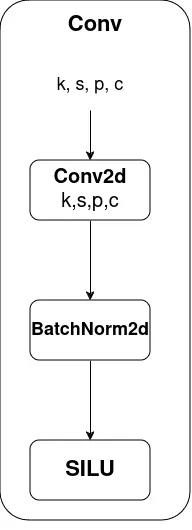
</div>
It is the most basic block in the architecture which consists of the Conv2d layer, BatchNorm2d layer, and SiLU activation function.

- Conv2d Layer: Convolution is a mathematical operation that involves sliding a small matrix (called a kernel or filter) over the input data, performing element-wise multiplication, and summing the results to produce a feature map. The “2D” in Conv2D refers to the fact that the convolution is applied in two spatial dimensions, typically height and width.

    + k: Number of filters or kernels. It represents the depth of the output volume, and each filter is responsible for detecting different features in the input.
    + s: Stride. It is the step size at which the filter/kernel slides over the input. A larger stride reduces the spatial dimensions of the output volume.
    + p: Padding. Padding is the additional border of zeros added to the input on each side. It helps preserve spatial information and can be used to control the spatial dimensions of the output volume.
    + c: Number of channels in the input. For example, in an RGB image, c would be 3 (one channel for each color: red, green, and blue).

- BacthNorm2d Layer: Batch Normalization (BatchNorm2d) is a technique used in deep neural networks to improve training stability and convergence speed. In the context of convolutional neural networks (CNNs), the BatchNorm2d layer specifically applies batch normalization to 2D inputs, which are typically the outputs of convolutional layers. It ensures that the numbers going through the network aren’t too big or too small. This helps in preventing problems during training.

- SiLU Activation Function: SiLU, which stands for Sigmoid Linear Unit, is an activation function used in neural networks. It is also known as the Swish activation function. The SiLU is defined as:
$$ SiLU(x) = x * \sigma(x) = \frac{x}{1 + e^{-x}}$$
Where $\sigma(x)$ is the sigmoid function. The key characteristic of SiLU is that it allows for smooth gradients, which can be beneficial during the training of neural networks. Smooth gradients can help avoid issues like vanishing gradients, which can impede the learning process in deep neural networks.


In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, k, s, p, c=3, dim=64, mc=512, w=1,flag=1):
        super(ConvBlock, self).__init__()
        dim = int(dim)
        out = min(dim,mc)*w
        self.conv = nn.Conv2d(in_channels=c, out_channels=out, kernel_size=k, stride=s, padding=p)
        self.batch_norm = nn.BatchNorm2d(num_features=out)
        self.activation = nn.SiLU()
    
    def forward(self, x):
        x = self.conv(x)
        x = self.batch_norm(x)
        x = self.activation(x)
        return x

#### Bottleneck Block

<div style="text-align: left;">
    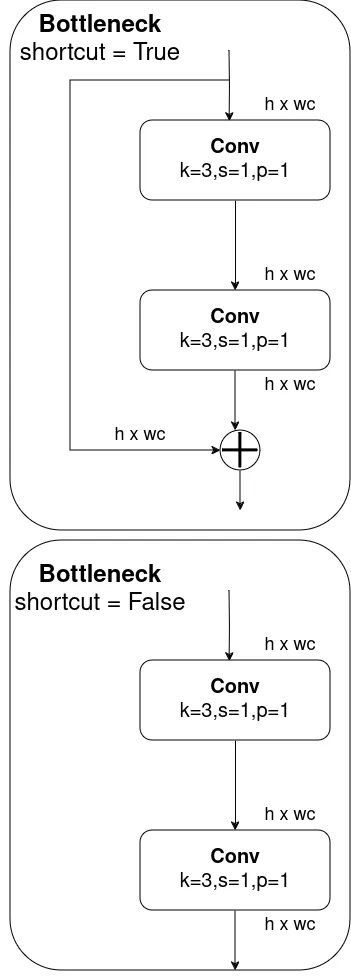
</div>

The bottleneck block consists of the Conv Block with a shortcut connection. If the shortcut=true then the shortcut is implemented in the bottleneck block else the input is passed through two Conv Blocks in a series. The shortcut connection, also known as a skip connection or residual connection, is a direct connection that bypasses one or more layers in the network. It allows the gradient to flow more easily through the network during training, addressing the vanishing gradient problem and making it easier for the model to learn. In the specific context of a bottleneck block, the shortcut connection allows the model to bypass the convolutional blocks if necessary. This way, the model can choose to use the identity mapping provided by the shortcut, making it easier to learn the identity function when needed. The inclusion of a shortcut connection enhances the ability of the model to learn complex representations and improves the training of deep CNNs preventing vanishing gradient problems. The vanishing gradient problem is a challenge that arises during the training of deep neural networks, particularly in architectures with many layers. It occurs when the gradients of the loss function concerning the parameters (weights) of the network become extremely small as they are backpropagated from the output layer to the input layer during the training process.

In [ ]:
class Bottleneck(nn.Module):
    def __init__(self, k=3, s=1, p=1, c=3, dim=64, shortcut=True):
        super(Bottleneck, self).__init__()
        self.conv1 = ConvBlock(k,s,p,c,dim=dim,mc=512)
        self.conv2 = ConvBlock(k,s,p,c,dim=dim,mc=512)
        self.short = shortcut
    
    def forward(self, x):

        if self.short: 
            res = self.conv1(x)
            res = self.conv2(res)
            return x + res
        else: 
            res = self.conv1(x)
            res = self.conv2(x)
            return res 
            

#### C2f Block

<div style="text-align: left;">
    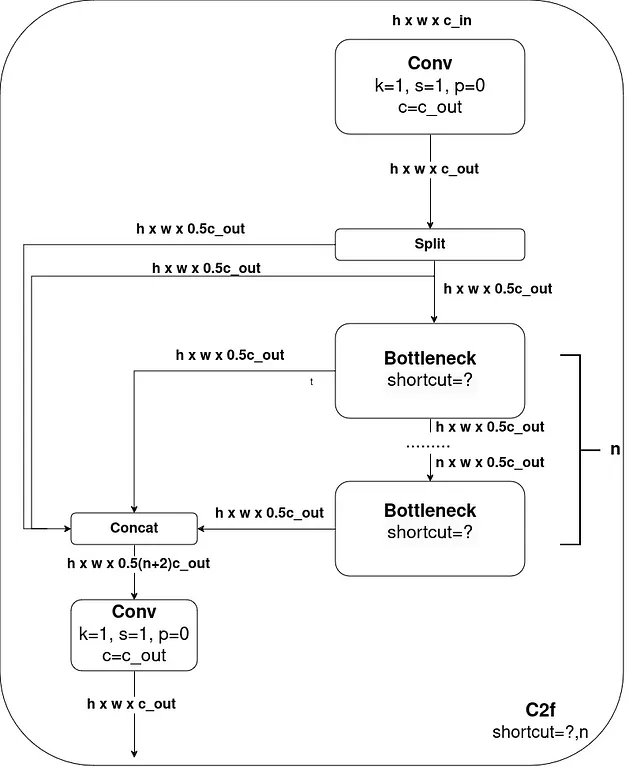
</div>


C2f block consists of a convolutional block which then the resulting feature map will be split. One feature map goes to the Bottleneck block whereas the other goes directly to the Concat block. In the C2f block, the number of the Bottleneck blocks used is defined by the depth_multiple parameter of the model. At the end, the feature map from the bottleneck block and the split feature map are concatenated and inputted into a final convolutional block.

In [ ]:
class C2fBlock(nn.Module):
    def __init__(self, k=1, s=1, p=0, c=3, depth_multiple=1, shortcut=True, dim=64, mc=512, w=1, flag=1):
        super(C2fBlock, self).__init__() 
        self.conv1 = ConvBlock(k=1,s=1,p=0,c=c,dim=dim,mc=mc,w=w,flag=flag)
        half_c= int(dim / 2)
        if half_c == 512:
            half_dim = 512
        else:
            half_dim= int(dim / 2)
            
        if flag == 0: 
            self.bottlenecks = nn.ModuleList([Bottleneck(k=3,s=1,p=1,c=256,dim=256) for _ in range(depth_multiple)])
            new_input = int(512 / 2) * (depth_multiple + 2)
            self.conv2 = ConvBlock(k,s,p,c=new_input,dim=dim,mc=mc,w=w)
        else:
            self.bottlenecks = nn.ModuleList([Bottleneck(k=3,s=1,p=1,c=half_c,dim=half_dim) for _ in range(depth_multiple)])
            new_input = int(dim / 2) * (depth_multiple + 2)
            self.conv2 = ConvBlock(k,s,p,c=new_input,dim=dim,mc=mc,w=w)
    
    def forward(self, x):
        
        x = self.conv1(x)
              
       
        # Split the input tensor into two halves along the channel dimension
        x1, x2 = torch.split(x, x.size(1) // 2, dim=1)
        
        
        # Process the other half (x2) through the bottlenecks
        bottleneck_outputs = []
        # append half of the input before processing
        bottleneck_outputs.append(x2.clone())
        for bott in self.bottlenecks:
            x2 = bott(x2)
            bottleneck_outputs.append(x2.clone())
            
        # this will concatenate half of the input before processing
        # and after each bottleneck processing  
        
        concatenated_bottleneck_outputs = torch.cat(bottleneck_outputs, dim=1)

        # add the other half
        x = torch.cat((x1, concatenated_bottleneck_outputs), dim=1)
        x = self.conv2(x)
        return x

#### Spatial Pyramid Pooling Fast (SPPF) Block

<div style="text-align: left;">
    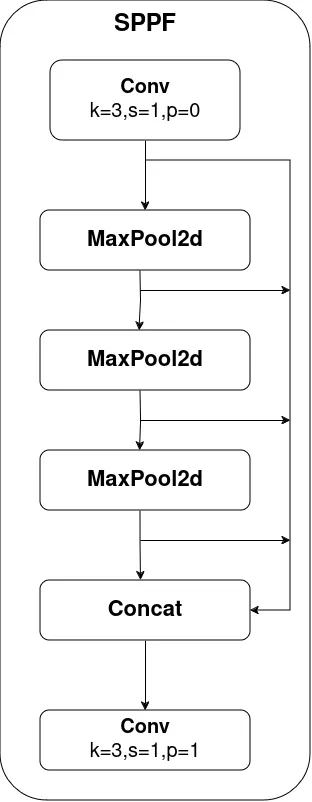
</div>

The SPPF Block consists of a convolutional block followed by three MaxPool2d layers. Every resulting feature map from the MaxPool2d layer is then concatenated at the end and fed to a convolutional block. The basic idea behind Spatial Pyramid Pooling is to divide the input image into a grid and pool features from each grid cell independently, allowing the network to handle images of different sizes effectively. In essence, Spatial Pyramid Pooling enables neural networks to work with images of different resolutions by capturing multi-scale information through pooling operations at different levels of granularity. This can be particularly useful in tasks such as object recognition, where objects may appear at different scales within an image. While SPP offers advantages, it can be computationally expensive. SPP-Fast addresses this by using a simpler pooling scheme. Instead of using multiple pooling levels with different kernel sizes, SPP-Fast might use a single fixed-size kernel for pooling, reducing the number of computations needed. SPP-Fast offers a trade-off between accuracy and speed. MaxPool2d Layer: Pooling layers are used to downsample the spatial dimensions of the input volume, reducing the computational complexity of the network and extracting dominant features. Max pooling is a specific type of pooling operation where, for each region in the input tensor, only the maximum value is retained, and the other values are discarded. In the case of MaxPool2d, the pooling is applied in both the height and width dimensions of the input tensor. The layer is defined by specifying parameters such as the size of the pooling kernel and the stride. The kernel size determines the spatial extent of each pooling region, and the stride determines the step size between successive pooling regions. The main function of the SPPF block is to generate the fixed feature representation of the object in various sizes in an image without resizing the image or introducing spatial information loss.

In [ ]:
class SPPF(nn.Module):
    def __init__(self, k=3, s=1, p=0, c=3, dim=64):
        super(SPPF, self).__init__() 
        
        self.conv1 = ConvBlock(k=k,s=s,p=0,c=c,dim=dim)
        self.pool1 = nn.MaxPool2d(kernel_size=5, stride=1, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=9, stride=1, padding=4)
        self.pool3 = nn.MaxPool2d(kernel_size=13, stride=1, padding=6)
        self.conv2 = ConvBlock(k=3,s=1,p=1,c=4*c,dim=dim)
        
    def forward(self, x):
        
        x = self.conv1(x)
        pool1 = self.pool1(x)
        pool2 = self.pool2(x)
        pool3 = self.pool3(x)
        x = torch.cat([x, pool1, pool2, pool3], dim=1)
        x = self.conv2(x)
        return x

#### Detect Block

<div style="text-align: left;">
    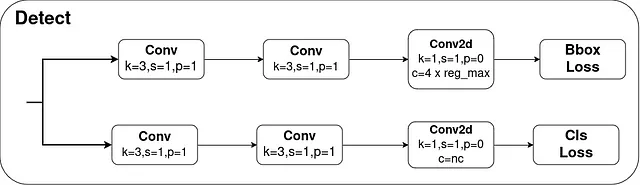
</div>

Detect Block is responsible for the detection of the objects. Unlike in previous versions of YOLO, YOLOv8 is an anchor-free model which means it predicts directly the center of an object instead of the offset from a known anchor box. Anchor-free detection reduces the number of box predictions, which speeds up complicated post-processing steps that sift through candidate detections after inference. The Detect Block contains two tracks. The first track is for bounding box predictions and the second track is for class predictions. Both tracks contain two convolutional blocks followed by a single Conv2d layer which gives the Bounding Box loss and Class Loss respectively.


IMPORTANT NOTE: we are using only one branch, predicting bbox coordinates, confidence and class. Another possible choice could be the one using two branches, one for bbox and confidence, and the second one (with the same layers applied) for the class probability. 

In [ ]:
class DetectBlock(nn.Module):
    def __init__(self, k=3, s=1, p=1, c=3, reg_max=1, nc=1, mc=512, w=1):
        super(DetectBlock, self).__init__()
        
        #nc = number of classes
        self.box_conv1 = ConvBlock(k,s,p,c=c,dim=64)
        self.box_conv2 = ConvBlock(k,s,p,c=64,dim=64)
        # 4 + 1 + 1 = 6 out_channels
        self.box_conv3 = nn.Conv2d(in_channels=64, out_channels=6, kernel_size=1, stride=1, padding=0)
        
        #self.class_conv1 = ConvBlock(k,s,p,c,dim=64)
        #self.class_conv2 = ConvBlock(k,s,p,c=64,dim=64)
        #self.class_conv3 = nn.Conv2d(in_channels=64, out_channels=nc, kernel_size=1, stride=1, padding=0)
        
    def forward(self, x): 
        
        if DEBUG_2:
            print("[Detect:]")
            print(f"Input: {x.shape}")
            print("\t [Conv]")
        ret1 = self.box_conv1(x)
        if DEBUG_2:
            print(f"Output: {ret1.shape}")
            print("\t [Conv]")
        ret1 = self.box_conv2(ret1)
        if DEBUG_2:
            print(f"Output: {ret1.shape}")
            print("\t [Conv2D]")
            print(self.box_conv3)
        ret1 = self.box_conv3(ret1)
        if DEBUG_2:
            print(f"Output: {ret1.shape}")
        
        #ret2 = self.class_conv1(x)
        #ret2 = self.class_conv2(ret2)
        #ret2 = self.class_conv3(ret2)
        
        return ret1#, ret2

### The Three parts of YOLO-v8
Now that we have explain the single blocks, we can introduce the whole architecture of YOLO-v8

<div style="text-align: left;">
    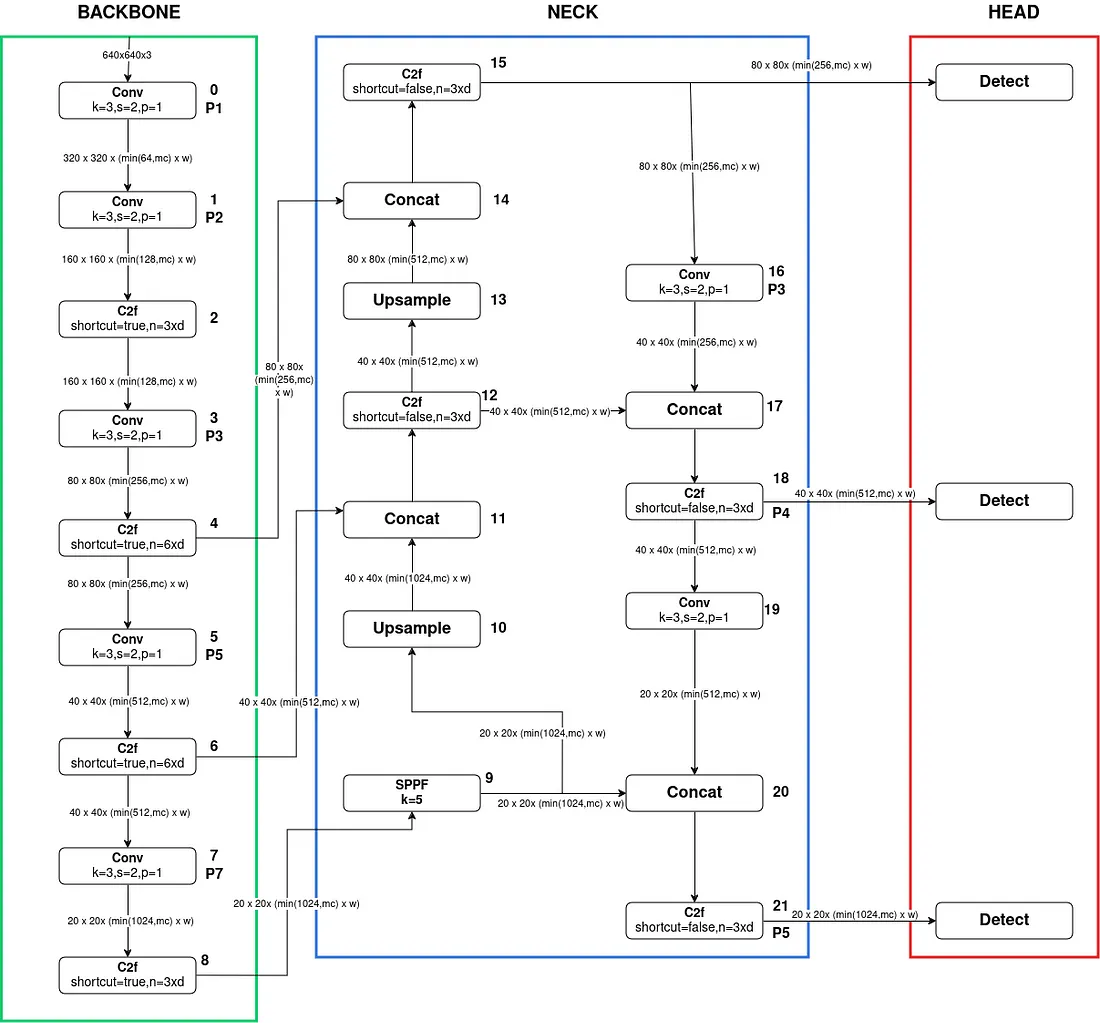
</div>
YOLOv8 Architecture consists of three main sections: Backbone, Neck, and Head.

- Backbone is the deep learning architecture that acts as a feature extractor of the inputted image.

- Neck combines the features acquired from the various layers of the Backbone module. This section is responsible for upsampling the feature map and combining the features acquired from the various layers of the Backbone section. Here, concat Block sums off the output channels of the blocks that are being concatenated without any change in resolution.

- Head predicts the classes and the bounding box of the objects which is the final output produced by the object detection model.

Each of the constituent blocks has an identifier within the architecture. Note that in the diagram an image of size 640 x 640 is input to the model, while, for the original dimensions of image in our dataset, we decided to go for 128 x 128. This will change the dimensions of the intermediate block and of the output.

IMPORTANT NOTE: we are using one detect. Using three detect, as in the diagram, would have allowed different detections specialized for different size:
- The first Detect block in the Head section specializes in detecting small objects that are inputted from the C2f block present in Block 15. In fact, it has a smaller grid size
- The second Detect block in the Head section specializes in detecting medium-sized objects which is inputted from the C2f block present in Block 18.
- The third Detect block in the Head section specializes in detecting small objects that are inputted from the C2f block present in Block 21. In fact, it has the larger grid size

In [7]:
class BackBone(nn.Module):
    def __init__(self, k=3, s=2, p=1, depth=1):
        super(BackBone, self).__init__()
        
        self.conv1 = ConvBlock(k,s,p)
        self.conv2 = ConvBlock(k,s,p, dim=128, c=64)
        self.c2f = C2fBlock(k=1,s=1,p=0,depth_multiple=3*depth,dim=128, c=128)
        self.conv3 = ConvBlock(k,s,p, dim=256, c=128)
        self.c2f_second = C2fBlock(k=1,s=1,p=0,depth_multiple=6*depth,dim=256, c=256)
        self.conv4 = ConvBlock(k,s,p,dim=512, c=256)
        self.c2f_third = C2fBlock(k=1,s=1,p=0,depth_multiple=6*depth,dim=512, c=512)
        self.conv5 = ConvBlock(k,s,p,dim=1024, c=512)
        self.c2f_last = C2fBlock(k=1,s=1,p=0,depth_multiple=3*depth,dim=min(1024,512), c=512)
        
    def forward(self, x):
        if DEBUG:
            print("[Layer: Conv 0]")
            print(f"Input Tensor Shape:  {x.shape}")
        x = self.conv1(x)
        if DEBUG:
            print(f"Output Tensor Shape: {x.shape}")

            print("[Layer: Conv 1]")
            print(f"Input Tensor Shape:  {x.shape}")
        x = self.conv2(x)
        if DEBUG:
            print(f"Output Tensor Shape: {x.shape}")

            print("[Layer: C2f 2]")
            print(f"Input Tensor Shape:  {x.shape}")
        x = self.c2f(x)
        if DEBUG:
            print(f"Output Tensor Shape: {x.shape}")

            print("[Layer: Conv 3]")
            print(f"Input Tensor Shape:  {x.shape}")        
        x = self.conv3(x)
        if DEBUG:
            print(f"Output Tensor Shape: {x.shape}")

            print("[Layer: C2f 4]")
            print(f"Input Tensor Shape:  {x.shape}") 
        x_first = self.c2f_second(x)
        if DEBUG:
            print(f"Output Tensor Shape: {x_first.shape}")

            print("[Layer: Conv 5]")
            print(f"Input Tensor Shape:  {x_first.shape}") 
        x = self.conv4(x_first)
        if DEBUG:
            print(f"Output Tensor Shape: {x.shape}")

            print("[Layer: C2f 6]")
            print(f"Input Tensor Shape:  {x.shape}") 
        x_second = self.c2f_third(x)
        if DEBUG:
            print(f"Output Tensor Shape: {x_second.shape}")

            print("[Layer: Conv 7]")
            print(f"Input Tensor Shape:  {x_second.shape}")
        x = self.conv5(x_second)
        if DEBUG:
            print(f"Output Tensor Shape: {x.shape}")

            print("[Layer: C2f 8]")
            print(f"Input Tensor Shape:  {x.shape}")
        x_last = self.c2f_last(x)
        if DEBUG:
            print(f"Output Tensor Shape: {x_last.shape}")
        
        return x_first, x_second, x_last
    
class Neck(nn.Module):
    def __init__(self, depth=1, scale=2):
        super(Neck, self).__init__()
        
        self.sppf = SPPF(k=1,dim=1024,c=512)
        self.upsample1 = nn.Upsample(scale_factor=2)
        self.upsample2 = nn.Upsample(scale_factor=2)
        self.c2f_block1 = C2fBlock(dim=512,c=1024,flag=1,shortcut=False)
        self.c2f_block2 = C2fBlock(dim=256,c=768,flag=1,shortcut=False) 
        self.c2f_block3 = C2fBlock(dim=512,c=768,flag=1,shortcut=False)
        self.c2f_block4 = C2fBlock(dim=1024,c=1024,flag=0,shortcut=False)
        self.conv1 = ConvBlock(k=3,s=2,p=1,dim=256,c=256)
        self.conv2 = ConvBlock(k=3,s=2,p=1,dim=512,c=512)
        
    def forward(self, x_first, x_second, x_last):
        
        if DEBUG:
            print("[Layer: SPPF 9]")
            print(f"Input Tensor Shape:  {x_last.shape}")
        out_sppf = self.sppf(x_last)
        if DEBUG:
            print(f"Output Tensor Shape: {out_sppf.shape}")

            print("[Layer: Upsample 10]")
            print(f"Input Tensor Shape:  {out_sppf.shape}")
        x = self.upsample1(out_sppf)
        if DEBUG:
            print(f"Output Tensor Shape: {x.shape}")

            print("[Layer: Concat 11]")
            print(f"Input Tensor Shape:  {x.shape}, {x_second.shape}")
        x = torch.cat((x,x_second), dim=1)
        if DEBUG:
            print(f"Output Tensor Shape: {x.shape}")

            print("[Layer: C2f 12]")
            print(f"Input Tensor Shape:  {x.shape}")
        conc1 = self.c2f_block1(x)
        if DEBUG:
            print(f"Output Tensor Shape: {conc1.shape}")

            print("[Layer: Upsample 13]")
            print(f"Input Tensor Shape:  {conc1.shape}")
        x = self.upsample2(conc1)
        if DEBUG:
            print(f"Output Tensor Shape: {x.shape}")

            print("[Layer: Concat 14]")
            print(f"Input Tensor Shape:  {x.shape}, {x_first.shape}")
        x = torch.cat((x,x_first), dim=1)
        if DEBUG:
            print(f"Output Tensor Shape: {x.shape}")

            print("[Layer: C2f 15]")
            print(f"Input Tensor Shape:  {x.shape}")
        det1 = self.c2f_block2(x)
        if DEBUG:
            print(f"Output Tensor Shape: {det1.shape}")

            print("[Layer: Conv 16]")
            print(f"Input Tensor Shape:  {det1.shape}")
        x = self.conv1(det1)
        if DEBUG:
            print(f"Output Tensor Shape: {x.shape}")

            print("[Layer: Concat 17]")
            print(f"Input Tensor Shape:  {x.shape}, {conc1.shape}")
        x = torch.cat((x,conc1), dim=1)
        if DEBUG:
            print(f"Output Tensor Shape: {x.shape}")

            print("[Layer: C2f 18]")
            print(f"Input Tensor Shape:  {x.shape}")
        det2 = self.c2f_block3(x)
        if DEBUG:
            print(f"Output Tensor Shape: {det2.shape}")

            print("[Layer: Conv 19]")
            print(f"Input Tensor Shape:  {det2.shape}")
        x = self.conv2(det2)
        if DEBUG:
            print(f"Output Tensor Shape: {x.shape}")

            print("[Layer: Concat 20]")
            print(f"Input Tensor Shape:  {x.shape}, {out_sppf.shape}")
        x = torch.cat((x,out_sppf), dim=1)
       
        if DEBUG:
            print(f"Output Tensor Shape: {x.shape}")

            print("[Layer: C2f 21]")
            print(f"Input Tensor Shape:  {x.shape}")
        det3 = self.c2f_block4(x)
        if DEBUG:
            print(f"Output Tensor Shape: {det3.shape}")
        
        return det1, det2, det3
    
class Head(nn.Module):
    def __init__(self):
        super(Head, self).__init__()
        
        #self.det1 = DetectBlock(c=256)
        #self.det2 = DetectBlock(c=512)
        self.det3 = DetectBlock(c=512)
        
    def forward(self, x3):
        #return self.det1(x1), self.det2(x2), self.det3(x3)
        return self.det3(x3)
    
class YOLO(nn.Module):
    def __init__(self):
        super(YOLO, self).__init__()
        self.h1 = BackBone()
        self.h2 = Neck()
        self.h3 = Head()
        
    def forward(self, x): 
        
        if DEBUG:
            print("---------- Backbone ----------")
            print("[Backbone Input]")
            print(f"Input Tensor Shape: {x.shape}")
        res1, res2, res3 = self.h1(x)
        if DEBUG:
            print("[Backbone Output]")
            print(f"Output Tensor Shape: \n\t\t     {res1.shape}, \n\t\t     {res2.shape}, \n\t\t     {res3.shape}")
            print("------------------------------")

        if DEBUG:
            print("---------- Neck ----------")
            print("[Neck Input]")
            print(f"Input Tensor Shape:  \n\t\t     {res1.shape}, \n\t\t     {res2.shape}, \n\t\t     {res3.shape}")
        det1, det2, det3 = self.h2(res1, res2, res3)
        if DEBUG:
            print("[Neck Output]")
            print(f"Output Tensor Shape: \n\t\t     {det1.shape}, \n\t\t     {det2.shape}, \n\t\t     {det3.shape}")
            print("------------------------------")

        if DEBUG:
            print("---------- Head ----------")
            print("[Head Input]")
            #print(f"Input Tensor Shape: \n\t\t     {det1.shape}, \n\t\t     {det2.shape}, \n\t\t     {det3.shape}")
            print(f"Input Tensor Shape: \n\t\t  {det3.shape}")
        det3 = self.h3(det3)
        if DEBUG:
            print("[Head Output]")
            #print(f"Output Tensor Bbox Loss: \n\t\t     {det1.shape}, \n\t\t     {det2.shape}, \n\t\t     {det3.shape}")
            print(f"Output Tensor Bbox Loss: \n\t\t     {det3.shape}")
            #print(f"Output Tensor Cls Loss: \n\t\t     {det1[1].shape}, \n\t\t     {det2[1].shape}, \n\t\t     {det3[1].shape}")
            print("------------------------------")

        #return det1, det2, det3
        m = torch.nn.Sigmoid()
        return m(det3)
    

## Loss Calculation

### Yolo-v8 Loss Calculation

$$
\displaystyle\sum_{x,y} \frac{\lambda_{box}}{N_{pos}}\mathcal{L}_{box} + \frac{\lambda_{cls}}{N_{pos}}\mathcal{L}_{cls} + \frac{\lambda_{dfl}}{N_{pos}}\mathcal{L}_{dfl} + \phi||\theta||_2^2
$$

Where:

$$
\mathcal{L}_{box} = \mathbb{1}_{c*_{x,y}}[1 - q_{x,y} + \frac{||b_{x,y} - \hat{b}_{x,y}||_2^2}{\rho^2} + \alpha_{x,y}v_{x,y}]
$$

$$
\mathcal{L}_{cls} = \sum_{c \in classes}y_c\log(\hat{y_c}) + (1- y_c)\log(1 - \hat{y_c})
$$

$$
\mathcal{L}_{dfl} = \mathbb{1}_{c*_{x,y}}[- (q_{(x,y) + 1} - q_{x,y})\log(\hat{q}_{x,y}) + (q_{x,y} - q_{(x,y) - 1})\log(\hat{q}_{(x,y) + 1})]
$$

With:

$$
q_{x,y} = IoU_{x,y} = \frac{\hat{\beta}_{x,y} \cap \beta_{x,y}}{\hat{\beta}_{x,y} \cup \beta_{x,y}}
$$

$$
v_{x,y} = \frac{4}{\pi^2}(\arctan(\frac{w_{x,y}}{h_{x,y}}) - \arctan(\frac{\hat{w}_{x,y}}{\hat{h}_{x,y}}))^2
$$


$$
\alpha_{x,y} = \frac{v_{x,y}}{1 - q_{x,y}}
$$

$$
\hat{q}_{x,y} = softmax()
$$

- $N_{pos}$: number of cells containing an object
- $\mathbb{1}_{c*_{x,y}}$: indicator function, 1 when the cell $(x,y)$ contains an object, 0 otherwise.
- $\beta_{x,y}$: the ground truth bbox
- $\hat{\beta}_{x,y}$: the predicted bbox
- $b_{x,y}$: central point of the ground truth bbox
- $b_{x,y}$: central point of the predicted bbox
- $y_c$: ground truth label for class c
- $q_{(x,y)+1}$ and $q_{(x,y)-1}$: nearest predicted boxes IoUs
- $w_{x,y}$ and $h_{x,y}$: width and height of the bbox
- $\rho$: diagonal lenght of the smallest enclosing box coverting the predicted and ground truth bbox.


#### Yolo-v8 Loss Hyperparameters

* `LAMBDA_BOX`
* `LAMBDA_CLS`
* `LAMBDA_DFL`

In [9]:
LAMBDA_BOX = 5.5
LAMDBA_CLS = 1

In [10]:
def compute_IoU(beta_output, beta_target):
    
    x_center_output = beta_output[0]
    y_center_output = beta_output[1]
    width_output = beta_output[2]
    heigth_output = beta_output[3]

    x_center_target = beta_target[0]
    y_center_target = beta_target[1]
    width_target = beta_target[2]
    heigth_target = beta_target[3]
    
    
    # first convert from the YOLO format to (x_min, y_min, x_max, y_max)
    xmin_output = (2*x_center_output - width_output) / 2
    ymin_output = (2*y_center_output - heigth_output) / 2
    xmax_output = (2*x_center_output + width_output) / 2 
    ymax_output = (2*y_center_output + heigth_output) / 2

    boxA = [xmin_output, ymin_output, xmax_output, ymax_output]

    xmin_target = (2*x_center_target - width_target) / 2
    ymin_target = (2*y_center_target - heigth_target) / 2
    xmax_target = (2*x_center_target + width_target) / 2 
    ymax_target = (2*y_center_target + heigth_target) / 2

    boxB = [xmin_target, ymin_target, xmax_target, ymax_target]
    
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou


def compute_box_loss(N_POS, indicator, beta_output, beta_target):
    x_center_output = beta_output[0]
    y_center_output = beta_output[1]
    width_output = beta_output[2]
    heigth_output = beta_output[3]

    x_center_target = beta_target[0]
    y_center_target = beta_target[1]
    width_target = beta_target[2]
    heigth_target = beta_target[3]

    q = compute_IoU(beta_output, beta_target)

    # Compute the L2 norm
    diff = ((x_center_target - x_center_output),(y_center_target - y_center_output))
    l2_norm = sum(x**2 for x in diff) ** 0.5
    
    #l2_norm = torch.linalg.norm(diff, ord=2)

    # RHO = 1 BECAUSE YES
    rho = 1

    # I am assuming v_xy is = v in the paper
    v = (4/math.pi**2) * (math.atan2(width_target, heigth_target) - math.atan2(width_output, heigth_output)) ** 2

    alpha = v / (1 - q)

    box_loss = (LAMBDA_BOX / N_POS) * indicator * ((1 - q) + (l2_norm / rho**2) + (alpha*v))
    
    return box_loss
    
def compute_cls_loss(N_POS, y_output, y_target):
    
    binary_cross_entropy = y_target*math.log(y_output) + (1 - y_target)*math.log(1 - y_output)
    
    # JUST 1 CLASS
    cls_loss = (LAMBDA_CLS / N_POS) * binary_cross_entropy
    
    return cls_loss

def compute_loss(N_POS, indicator, beta_output, beta_target, y_output, y_target):
    
    box_loss = compute_box_loss(N_POS, indicator, beta_output, beta_target)
    
    cls_loss = compute_cls_loss(N_POS, y_output, y_target)
    
    total_loss = box_loss + cls_loss 
    
    return total_loss

In [11]:
def show_image_and_bbox(image, encoding_of_boxes, filename=None, training=False):
    
    image_np = None

    # if a filename is not provided, a 128 x 128 image is displayed
    if filename == None:
        image = image[0]

        if image.shape == torch.Size([3, 128, 128]):
            image_np = image.permute(1, 2, 0).numpy()

    # if a filename is provided, the 676 x 380 image is displayed
    else:
        img_path = os.path.join("/kaggle/input/car-object-detection/data/testing_images", filename)
    
        if training == True:
            img_path = os.path.join("/kaggle/input/car-object-detection/data/training_images", filename)
    
        image = Image.open(img_path).convert("RGB")
        image_np = np.array(image)
            
    # Plot the image with bounding boxes
    fig, ax = plt.subplots(1)
    ax.imshow(image_np)
    
    bboxes = from_grid_coordinate_to_bbox(encoding_of_boxes)

    for box in bboxes:
        
        #print(f"box = {box}")

        x_center = box[0]
        y_center = box[1]
        width = box[2]
        height = box[3]
        
        xmin = (2*x_center - width) / 2
        ymin = (2*y_center - height) / 2
        xmax = (2*x_center + width) / 2
        ymax = (2*y_center + height) / 2
        
        rect = None
        # if a filename is not provided, the image is 128 x 128 and so the box should be
        if filename == None:
            rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
        
        # if the image is 676 x 380, the rectangle must be scaled
        else:
            bbox = scale_to_range(bboxes=[[xmin, ymin, xmax, ymax]], old_x=128, old_y=128, new_x=676, new_y=380)
            bbox = bbox[0]
            xmin = bbox[0]
            ymin = bbox[1]
            xmax = bbox[2]
            ymax = bbox[3]
            width = xmax - xmin
            height = ymax - ymin
            rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
        
        
        # Add the patch to the Axes
        ax.add_patch(rect)
        
        
        confidence_score = box[4]
        ax.text(xmin, ymin - 5, f'{confidence_score:.4f}', color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

    
    plt.axis('off')  # Turn off axis
    plt.show()
    
    return 

### Yolo-v1 Loss Calculation

We have modified the classic Yolo-v1 loss, adding a cls loss calculation term also for no-object cell. Given position $(x,y)$ for each cell of the grid, we have that the loss is: 

$$
\displaystyle\sum_{x,y} (\mathcal{L}_{obj} + \lambda_{no-obj}\mathcal{L}_{no-obj})
$$

Where the loss function used when a cell contains an object is:
$$
\mathcal{L}_{obj} = \lambda_{coord}\mathcal{L}_{obj-box} + \mathcal{L}_{obj-conf} + \mathcal{L}_{obj-class} 
$$

With: 

$$
\mathcal{L}_{obj-box} = (\hat{\Delta{x}} - \Delta{x})^2 + (\hat{\Delta{y}} - \Delta{y})^2 + (\sqrt{\hat{\Delta{w}}} - \sqrt{\Delta{w}})^2 + (\sqrt{\hat{\Delta{h}}} - \sqrt{\Delta{h}})^2
$$

$$
\mathcal{L}_{obj-conf} = (\hat{{C}} - {C})^2 
$$

$$
\mathcal{L}_{obj-cls} = (\hat{p} - {p})^2 
$$
with $C = 1$ and $p = 1$

While the loss function used when a cell does not contain an object is:
$$
\mathcal{L}_{obj} = \mathcal{L}_{no-obj-conf} + \mathcal{L}_{no-obj-class}
$$
With analogous expression for the class and confidence losses, with the only difference of $C = 0$ and $p = 0$

#### Yolo-v1 Loss Hyperparameters

* `LAMBDA_COORD`: when > 1 it puts more importance on box parameters than cls and confidence
* `LAMBDA_NO_OBJ`: when < 1 it puts more importance on grid cells that contain object than cells which don't

In [13]:
LAMBDA_COORD = 5
LAMBDA_NO_OBJ = 1

In [14]:
def compute_V1_loss(target, output, obj_indicator, no_obj_indicator): 
    
    loss_box_obj_DELTA_X = (target[0][DELTA_X][i][j] - output[0][DELTA_X][i][j])**2
    loss_box_obj_DELTA_Y = (target[0][DELTA_Y][i][j] - output[0][DELTA_Y][i][j])**2
    loss_box_obj_WIDTH = (torch.sqrt(target[0][WIDTH][i][j]) - torch.sqrt(output[0][WIDTH][i][j]))**2
    loss_box_obj_HEIGHT = (torch.sqrt(target[0][HEIGHT][i][j]) - torch.sqrt(output[0][HEIGHT][i][j]))**2
    loss_box_obj = loss_box_obj_DELTA_X + loss_box_obj_DELTA_Y + loss_box_obj_WIDTH + loss_box_obj_HEIGHT
    loss_conf_obj = (target[0][CONFIDENCE][i][j] - output[0][CONFIDENCE][i][j])**2
    loss_cls_obj = (target[0][CLASS][i][j] - output[0][CLASS][i][j])**2
    cell_loss_obj = obj_indicator*((LAMBDA_COORD*loss_box_obj) + loss_conf_obj + loss_cls_obj)
    loss_conf_no_obj = (target[0][CONFIDENCE][i][j] - output[0][CONFIDENCE][i][j])**2
    loss_cls_no_obj = (target[0][CLASS][i][j] - output[0][CLASS][i][j])**2
    cell_loss_no_obj = LAMBDA_NO_OBJ * no_obj_indicator * (loss_conf_no_obj + loss_cls_no_obj)
    total_loss = cell_loss_obj + cell_loss_no_obj
    
    return total_loss

## Training Phase

### Debugging Options:

- `DEBUG`: first level of granularity, if `True` input and output dimensions of the main block of the Yolo-v8 architecture are shown
- `DEBUG_2`: second level of granularity, it shows input and output dimensions of internal sub-block too.

In [ ]:
DEBUG = False
DEBUG_2 = False

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
if TRAINING == True:

    num_epochs = 700

    csv_file = '/kaggle/input/car-object-detection/data/train_solution_bounding_boxes (1).csv'
    img_dir = '/kaggle/input/car-object-detection/data/training_images'
    transform = transforms.Compose([
        #data aug 
        # TRY MOSAIC AUGMENTATION
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
    ])

    if DEBUG:
        print("========================================")
        print("        YOLOv8 Model Debug Output       ")
        print("========================================")
    model = YOLO()

    dataset = YOLODataset(csv_file=csv_file, img_dir=img_dir, transform=transform)
    #dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=1)


    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        
        for image, target, N_POS in dataloader:
            
            # just for debugging
            #andand_bbox(image, target)

            target = target.to(device)
            image = image.to(device)

            optimizer.zero_grad()

            # Predizioni del modello
            output = model(image)

            n_row = target.shape[2]
            n_column = target.shape[3]

            
            total_loss = 0
            for i in range(0, n_row):
                for j in range(0, n_column):

                    # computing indicators for obj and no_obj loss
                    if target[0][CONFIDENCE][i][j] == 0: # -> there is no object!
                        obj_indicator = 0
                        no_obj_indicator = 1
                    else:
                        obj_indicator = 1
                        no_obj_indicator = 0

                    if V1_LOSS == True:
                        total_loss += compute_V1_loss(target, output, obj_indicator, no_obj_indicator)
                    else:
                        beta_output = output[0][:4][i][j]
                        beta_target = target[0][:4][i][j]
                        y_output = output[0][5][i][j]
                        y_target = target[0][5][i][j]
                        total_loss += compute_V8_loss(N_POS, obj_indicator, beta_output, beta_target, y_output, y_target)

            total_loss.backward()
            optimizer.step()

            epoch_loss += total_loss.item()

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(dataloader)}")

Epoch 1/700, Loss: 3.433526901124229
Epoch 2/700, Loss: 2.5630637076539053


KeyboardInterrupt: 

### Debug Training

This training loop is used to debug the training phase, in order to understand if the model is learning properly from the train-set

In [ ]:
if TRAINING_DEBUG == True:    
    
    # Initialize dataset and dataloader

    num_epochs = 20

    csv_file = '/kaggle/input/car-object-detection/data/train_solution_bounding_boxes (1).csv'
    img_dir = '/kaggle/input/car-object-detection/data/training_images'
    transform = transforms.Compose([
        #data aug 
        # TRY MOSAIC AUGMENTATION
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
    ])

    if DEBUG:
        print("========================================")
        print("        YOLOv8 Model Debug Output       ")
        print("========================================")
    model = YOLO()

    dataset = YOLODataset(csv_file=csv_file, img_dir=img_dir, transform=transform)
    

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    model.to(device)

    print("STARTING....\n")
    for epoch in range(num_epochs):
        
        model.train()
        epoch_loss = 0.0
        
        # prendi l'immagine 
        image, target, N_POS = dataset.get_item_debug("vid_4_28220.jpg")
        
        # to add the batch_size dimension as the dataloader does
        image = image.unsqueeze(0)
        target = target.unsqueeze(0)
        
        if epoch == 0:
            #just for debugging
            show_image_and_bbox(image, target)
            print(f"[TARGET:] = \n {target}\n")

        target = target.to(device)
        image = image.to(device)
        

        optimizer.zero_grad()

        # Predizioni del modello
        output = model(image)
        
        print(f"[OUTPUT:] = \n {output}\n")
        
        n_row = target.shape[2]
        n_column = target.shape[3]


        print("CALCULATE LOSS BETWEEN [TARGET] AND [OUTPUT]\n")
        total_loss = 0
        for i in range(0, n_row):
            for j in range(0, n_column):
                print(f"\tGrid Cell: row {i} column {j}\n")

                # computing indicators for obj and no_obj loss
                if target[0][CONFIDENCE][i][j] == 0: # -> there is no object!
                    obj_indicator = 0
                    no_obj_indicator = 1
                else:
                    obj_indicator = 1
                    no_obj_indicator = 0

                if V1_LOSS == True:
                    total_loss += compute_V1_loss(target, output, obj_indicator, no_obj_indicator)
                    print("\n")
                else:
                    beta_output = output[0][:4][i][j]
                    beta_target = target[0][:4][i][j]
                    y_output = output[0][5][i][j]
                    y_target = target[0][5][i][j]
                    total_loss += compute_V8_loss(N_POS, obj_indicator, beta_output, beta_target, y_output, y_target)

        total_loss.backward()
        optimizer.step()

        epoch_loss += total_loss.item()

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / 1}")
        show_image_and_bbox(image.cpu(), output)
        print("\n")

## Save the Model after Training

In [ ]:
if SAVE == True and TRAINING == True and TRAINING_DEBUG == False:
    torch.save(model.state_dict(), '/kaggle/working/yolov8_new_700_epoch.pth')
    print("model saved")

In [ ]:
# This section is only for train debugging
if SAVE == True and TRAINING_DEBUG == True and TRAINING == False:
    !mkdir /kaggle/working/debugging
    torch.save(model.state_dict(), '/kaggle/working/debugging/yolov8_new_100_epoch_DEBUGGING.pht')
    print("debug model saved")